<a href="https://colab.research.google.com/github/dubrovin-sudo/free_parking_space/blob/main/notebooks/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [2]:
!pip install tensorflow==1.15.0
!pip install keras==2.3.1
!pip install h5py==2.10.0
!pip install mrcnn
!pip install twilio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 21 kB/s 
     |████████████████████████████████| 503 kB 39.2 MB/s 
     |████████████████████████████████| 3.8 MB 21.0 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 4.1 MB 41.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=abf4304f3ef71e7a27b58f0b3ebe9a8d4abd814ba501dd5cfe4d57175d5e0fe5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tens

In [3]:
import cv2
import keras
import tensorflow
import numpy as np
import mrcnn.config
import mrcnn.utils

from mrcnn.model import MaskRCNN
from pathlib import Path
from twilio.rest import Client
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [4]:
# Конфигурация, которую будет использовать библиотека Mask-RCNN.
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # в датасете COCO находится 80 классов + 1 фоновый класс.
    DETECTION_MIN_CONFIDENCE = 0.6

In [5]:
# Фильтруем список результатов распознавания, чтобы остались только автомобили.
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # Если найденный объект не автомобиль, то пропускаем его.
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [6]:
# Конфигурация Twilio.
twilio_account_sid = 'AC9316b40a991db4be2865771a8575e8e1'
twilio_auth_token = '16286502aa93d0916810149642f38809'
twilio_phone_number = '+19785715741'
destination_phone_number = '+79111469111'
client = Client(twilio_account_sid, twilio_auth_token)

# Корневая директория проекта.
ROOT_DIR = Path(".")

# Директория для сохранения логов и обученной модели.
MODEL_DIR = ROOT_DIR / "logs"

# Локальный путь к файлу с обученными весами.
COCO_MODEL_PATH = ROOT_DIR / "mask_rcnn_coco.h5"

# Загружаем датасет COCO при необходимости.
if not COCO_MODEL_PATH.exists():
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

# Директория с изображениями для обработки.
IMAGE_DIR = ROOT_DIR / "images"

# Видеофайл или камера для обработки — вставьте значение 0, если использовать камеру, а не видеофайл.
VIDEO_SOURCE = "test_images/parking.mp4"

# Создаём модель Mask-RCNN в режиме вывода.
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Загружаем предобученную модель.
model.load_weights(str(COCO_MODEL_PATH), by_name=True)

# Местоположение парковочных мест.
parked_car_boxes = None

# Загружаем видеофайл, для которого хотим запустить распознавание.
video_capture = cv2.VideoCapture(VIDEO_SOURCE)

# Сколько кадров подряд с пустым местом мы уже видели.
free_space_frames = 0

# Мы уже отправляли SMS?
sms_sent = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


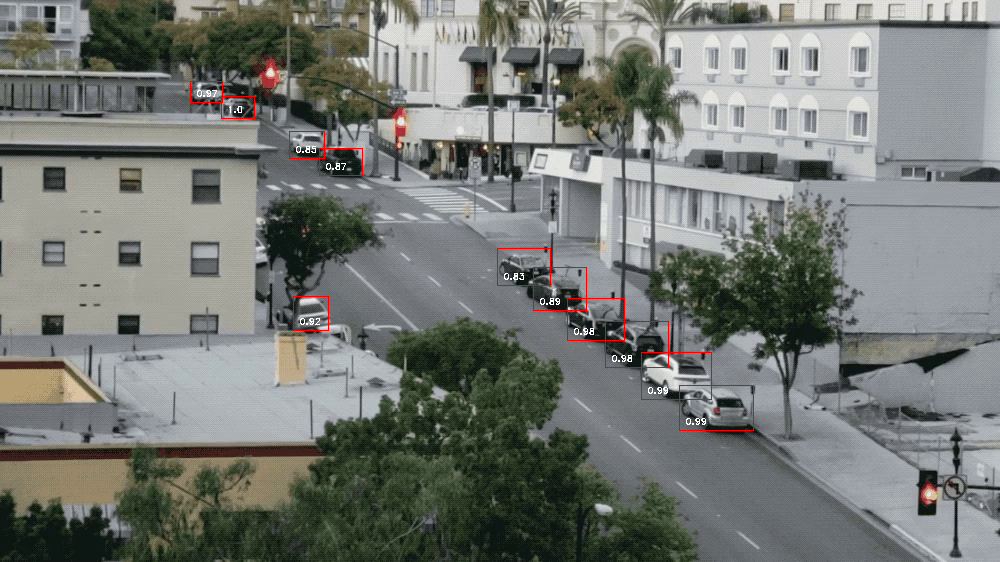

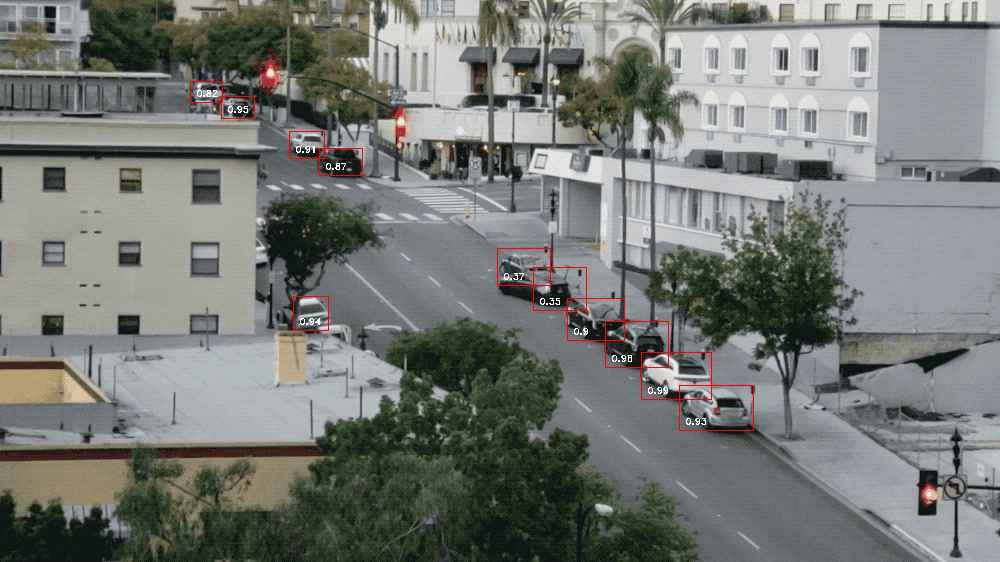

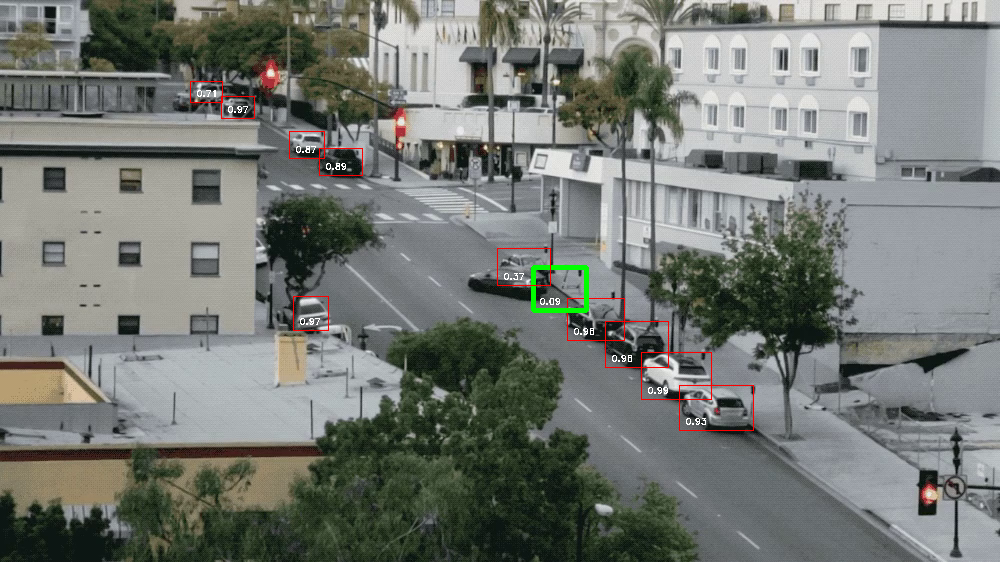

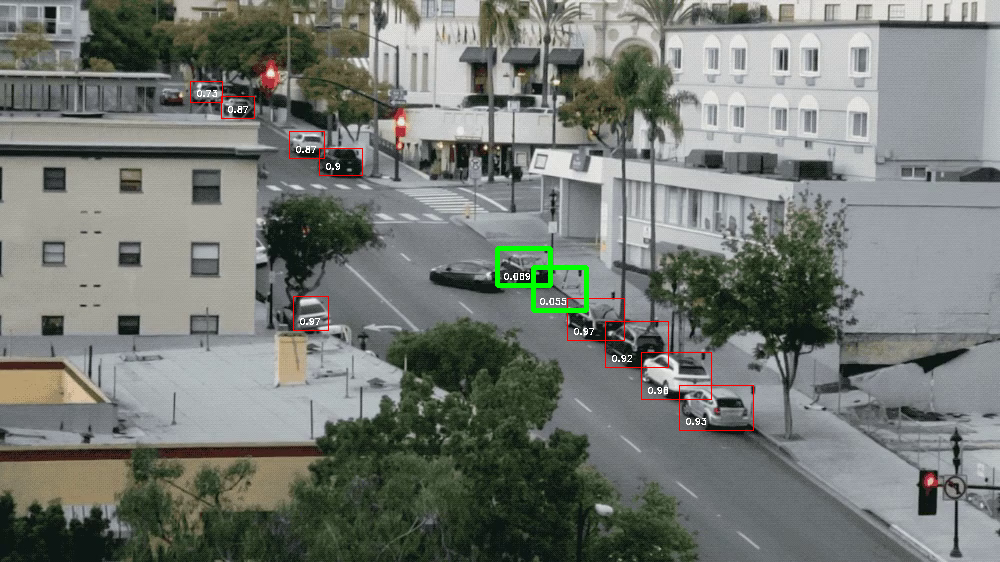

In [7]:
# Проходимся в цикле по каждому кадру.
while video_capture.isOpened():
    success, frame = video_capture.read()
    if not success:
        break

    # Конвертируем изображение из цветовой модели BGR в RGB.
    rgb_image = frame[:, :, ::-1]

    # Подаём изображение модели Mask R-CNN для получения результата.
    results = model.detect([rgb_image], verbose=0)

    # Mask R-CNN предполагает, что мы распознаём объекты на множественных изображениях.
    # Мы передали только одно изображение, поэтому извлекаем только первый результат.
    r = results[0]

    # Переменная r теперь содержит результаты распознавания:
    # - r['rois'] — ограничивающая рамка для каждого распознанного объекта;
    # - r['class_ids'] — идентификатор (тип) объекта;
    # - r['scores'] — степень уверенности;
    # - r['masks'] — маски объектов (что даёт вам их контур).

    if parked_car_boxes is None:
        # Это первый кадр видео — допустим, что все обнаруженные машины стоят на парковке.
        # Сохраняем местоположение каждой машины как парковочное место и переходим к следующему кадру.
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])
    else:
        # Мы уже знаем, где места. Проверяем, есть ли свободные.

        # Ищем машины на текущем кадре.
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # Смотрим, как сильно эти машины пересекаются с известными парковочными местами.
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        # Предполагаем, что свободных мест нет, пока не найдём хотя бы одно.
        free_space = False

        # Проходимся в цикле по каждому известному парковочному месту.
        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

            # Ищем максимальное значение пересечения с любой обнаруженной
            # на кадре машиной (неважно, какой).
            max_IoU_overlap = np.max(overlap_areas)

            # Получаем верхнюю левую и нижнюю правую координаты парковочного места.
            y1, x1, y2, x2 = parking_area

            # Проверяем, свободно ли место, проверив значение IoU.
            if max_IoU_overlap < 0.15:
                # Место свободно! Рисуем зелёную рамку вокруг него.
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # Отмечаем, что мы нашли как минимум оно свободное место.
                free_space = True
            else:
                # Место всё ещё занято — рисуем красную рамку.
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            # Записываем значение IoU внутри рамки.
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

        # Если хотя бы одно место было свободным, начинаем считать кадры.
        # Это для того, чтобы убедиться, что место действительно свободно
        # и не отправить лишний раз уведомление.
        if free_space:
            free_space_frames += 1
        else:
            # Если всё занято, обнуляем счётчик.
            free_space_frames = 0

        # Если место свободно на протяжении нескольких кадров, можно сказать, что оно свободно.
        if free_space_frames > 10:
            # Отображаем надпись SPACE AVAILABLE!! вверху экрана.
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"SPACE AVAILABLE!", (10, 150), font, 3.0, (0, 255, 0), 2, cv2.FILLED)

            # Отправляем сообщение, если ещё не сделали это.
            if not sms_sent:
                print("SENDING SMS!!!")
                message = client.messages.create(
                    body="Parking space open - go go go!",
                    from_=twilio_phone_number,
                    to=destination_phone_number
                )
                sms_sent = True

        # Показываем кадр на экране.
        cv2_imshow(frame)

    # Нажмите 'q', чтобы выйти.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Нажмите 'q', чтобы выйти.
video_capture.release()
cv2.destroyAllWindows()